<a href="https://colab.research.google.com/github/OmarShafie/HBKU_Projects/blob/master/Fawaed_bio_retrieval_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!pip install transformers
!git clone https://github.com/aub-mind/arabert
!pip install pyarabic
!pip install farasapy
!pip install arabic_reshaper
!pip install python-bidi
!pip install lime

fatal: destination path 'arabert' already exists and is not an empty directory.


In [4]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
import ast

from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

In [5]:
#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display

### Data Import

In [6]:
from collections import Counter
import matplotlib.pyplot as plt

###Assumptions:
* Clean (Zero-tags) is not really clean
* Non-Clean (atleast 1 dirty bit) == accurate labeling on all 13 categories


In [7]:
dataset_directory = 'gdrive/MyDrive/HBKU/Research/datasets/tutorial'
path_sen_tagged = dataset_directory + '/sen_tagged.csv'
df_sen_tagged = pd.read_csv(path_sen_tagged, header=0)
df_sen_tagged.tail()

Unnamed: 0  ...                                         embeddings
16269      513482  ...  [ 2.10690610e-02 -1.90586731e-01 -2.32950106e-...
16270      513546  ...  [ 3.17659855e-01 -2.56639928e-01 -3.61208542e-...
16271      513637  ...  [ 5.63444495e-01 -2.97480017e-01 -1.85146853e-...
16272      513638  ...  [ 2.63749480e-01 -9.16955844e-02 -2.09034830e-...
16273      513856  ...  [ 1.27087116e-01 -4.37129229e-01 -3.35567631e-...

[5 rows x 18 columns]

In [8]:
df_sen_tagged.dtypes

Unnamed: 0                     int64
BioID                          int64
text                          object
الإرسال                        int64
المفاضلة بين الرواة            int64
إثبات سماع الراوي              int64
التوثيق الضمني                 int64
الإدراك                        int64
الاختلاط                       int64
التدليس                        int64
الاختلاف في سماع الراوي        int64
المفاضلة بين الرواة في راو     int64
التضعيف الاستثنائي             int64
التوثيق الاستثنائي             int64
التضعيف الضمني                 int64
المفاضلة بين الرواة في بلد     int64
clean                           bool
embeddings                    object
dtype: object

In [9]:
#Correct datatype transformations for embedding column 
df_sen_tagged['embeddings'] = df_sen_tagged['embeddings'].apply(lambda x: np.fromstring( x.replace('[','').replace(']','').replace('  ',' '), sep=' '))
filter_na = df_sen_tagged['embeddings'].apply(lambda x: not any(np.isnan(x)))
df_corpus = df_sen_tagged[filter_na]

###Model parameters (To-do):
* The effect of dimension reduction - umap-learn
* Using sophisticated bert with little data
* Kitchen sink approach
* Mix and match based on best performance
* Classifier hyper parameter search / similarity measure to choose
* What threshold to filter
* Do we filter based on narrator biography or sentence scores

In [10]:
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score

from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

classifiers = {
    'LogisticRegression': {"Grid": True, "cls": LogisticRegression(C=1.0, penalty='l2', solver='newton-cg')},
    #'Ridge'             : {"Grid": False, "cls": RidgeClassifier()},
    'KNeighbors'        : {"Grid": True, "cls": KNeighborsClassifier(7)},
    'SVC'               : {"Grid": True, "cls": SVC(probability=True, C=0.025, gamma='scale', kernel='linear')},
    #'Bagging'           : {"Grid": False, "cls": BaggingClassifier()},
    'AdaBoost'          : {"Grid": False, "cls": AdaBoostClassifier()},
    'RandomForest'      : {"Grid": True, "cls": RandomForestClassifier(max_features='sqrt', n_estimators=100)},
    #'GradientBoosting'  : {"Grid": False, "cls": GradientBoostingClassifier()},
    'MLP'               : {"Grid": False, "cls": MLPClassifier(alpha=1, max_iter=1000)},
    #'DecisionTree'      : {"Grid": False, "cls": DecisionTreeClassifier(max_features='sqrt', max_depth=7)},
    #'MultinomialNB'     : {"Grid": False, "cls": MultinomialNB()},
    }

param_grid = {

    'LogisticRegression': { 'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                            'penalty': ['l2'],
                            'C': [100, 10, 1.0, 0.1, 0.01] },
    'Ridge'             : { 'alpha': np.arange(0.0, 1.0, 0.05)},
    'KNeighbors'        : { 'n_neighbors': np.arange(1, 17, 2),
                            'weights': ['uniform', 'distance'],
                            'metric': ['euclidean', 'manhattan', 'minkowski']},
    'SVC'               : { 'kernel': ['rbf', 'linear'], #'poly', 'sigmoid',
                            'C': [50, 10, 1.0, 0.1, 0.01],
                            'gamma': ['scale']},
    'Bagging'           : { 'n_estimators': [10, 100, 1000]},
    'RandomForest'      : { 'n_estimators': [10, 100, 1000],
                            'max_features': ['sqrt', 'log2']},
    'GradientBoosting'  : { 'n_estimators': [10, 100, 1000],
                            'learning_rate': np.arange(0.1, 1.0, 0.1),
                            'subsample': [0.5, 0.7, 1.0],
                            'max_depth': [3, 7, 9] },
    'AdaBoost'          : { 'n_estimators': np.arange(50, 100, 10),
                            'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5] },
    'MLP'               : { 'alpha': np.arange(0.0, 1.0, 0.001),
                            'learning_rate': ['constant', 'invscaling', 'adaptive'] },
    'DecisionTree'      : { 'max_features': ['sqrt', 'log2'],
                            'max_depth': [3, 7, 9] },
    'MultinomialNB'     : { 'alpha': np.arange(0.0, 1.0, 0.005) },
}

###Evaluation:
* Is this recall deriven vs f1 
* Average  recall jumps vs iterations


In [11]:
def plot_measures(scores, df, cat):
  fig, axs = plt.subplots(ncols=4)
  fig.set_figwidth(30)
  plt.title(get_display(arabic_reshaper.reshape(cat)))
  found_graph = sns.lineplot(data=pd.DataFrame.from_records(scores), x="User_input", y="Found_insights", hue="cls" ,style="cls", markers=True, ax=axs[0])
  found_graph.axhline(df[cat].sum())
  sns.lineplot(data=pd.DataFrame.from_records(scores), x="iteration", y="precision_score", hue="cls" ,style="cls", markers=True, ax=axs[1])
  sns.lineplot(data=pd.DataFrame.from_records(scores), x="iteration", y="recall_score", hue="cls" ,style="cls", markers=True, ax=axs[2])
  sns.lineplot(data=pd.DataFrame.from_records(scores), x="iteration", y="f1_score", hue="cls" ,style="cls", markers=True, ax=axs[3])
  #sns.lineplot(data=pd.DataFrame.from_records(scores), x="iteration", y="accuracy_score", hue="cls" ,style="cls", markers=True, ax=axs[4])
  plt.show(block=False)

In [12]:
def get_initial_query(df, k, gs, in_k):
  cat_filter = (df[k] == 1) if in_k else (df[k] != 1)
  sampled_text = df[cat_filter].sample(n=gs).loc[:, ('text')]
  return df['text'].isin(sampled_text)

In [13]:
def filter_using_cls(corpus, embeddings, lables, white_list, black_list, model, adaptation_size, in_adjustment, filter_by_books):

  query_x = embeddings[white_list | black_list]
  query_y = lables[white_list | black_list]
  model.fit(np.vstack(query_x.values), query_y.values)

  ###generate instances: pred on all corpus sentences
  vectors = np.vstack(embeddings.values)
  pred_prob = model.predict_proba(vectors)[:,1]
  corpus['pred'] = (1 - abs(pred_prob - prob_threshold)) if in_adjustment else pred_prob

  ###rank top predected (map sentences score to biographies, to score narrator)
  filter_unseen = (~(white_list | black_list))
  if filter_by_books:
    #take average of sentences of a book
    #print(corpus)
    docs = corpus[filter_unseen][['BioID','pred']].groupby('BioID', as_index=False).agg('sum')#max,avg,sum
    #print(docs)
    top_pred = docs.nlargest(adaptation_size, 'pred')
    #print(top_pred)
    result = corpus['BioID'].isin(top_pred['BioID'])
  else:
    top_pred = corpus[filter_unseen].nlargest(adaptation_size, 'pred')
    result = corpus['text'].isin(top_pred['text'])

  return result, pred_prob

In [14]:
def adaptive_filtering(df_corpus, cat, init_query_size, adaptation_size, prob_threshold, precision_halt, boundry_adjusments, n_folds, n_iter, filter_by_books):
  labels = df_corpus[cat] == 1
  scores = []

  ##Generate initial query random
  init_white_list = get_initial_query(df_corpus, cat, init_query_size, True)
  init_black_list = get_initial_query(df_corpus, cat, init_query_size, False)

  for cls in tqdm(classifiers):
    white_list = init_white_list #True Positive
    black_list = init_black_list #False Positive
    prev_white = black_list

    iteration = 0
    in_adjustment = True
    ##While more was discovered
    while (in_adjustment                                                                       or
           (any(white_list != prev_white)                                         or
            len(df_corpus[white_list])/(iteration*adaptation_size) > precision_halt)         ):
      iteration += 1
      in_adjustment = iteration < boundry_adjusments

      query_x = df_corpus[white_list | black_list]['embeddings']
      query_y = df_corpus[white_list | black_list][cat]

      #tune classifier using cross validation
      if n_folds > 0:
        if classifiers[cls]["Grid"]:
          cls_search = GridSearchCV(classifiers[cls]['cls'], param_grid[cls], cv=n_folds, n_jobs=-1, verbose=1)
        else:
          cls_search = RandomizedSearchCV(classifiers[cls]['cls'], param_grid[cls], cv=n_folds, n_jobs=-1, n_iter=n_iter)
        ###fit models
        cls_search.fit(np.vstack(query_x.values), query_y.values)
        #print(classifiers[cls], cls_search.best_params_)
        model = cls_search.best_estimator_
      else:
        model = classifiers[cls]['cls']

      ###Adapt: filter results
      adapt, pred_prob = filter_using_cls(df_corpus[['text','BioID']], df_corpus['embeddings'], df_corpus[cat], white_list, black_list, model, adaptation_size, in_adjustment, filter_by_books)
      pred = pred_prob > prob_threshold
      
      ###reveal labels and update
      prev_white = white_list
      white_list = white_list | (adapt & labels)
      black_list = black_list | (adapt & ~labels)

      scores.append({'cls': cls, 
                    'iteration': iteration, 
                    'User_input': (white_list | black_list).sum(), 
                    'Found_insights': len(df_corpus[white_list]), 
                    'precision_score': precision_score(labels, pred, average='binary'),
                    'recall_score': recall_score(labels, pred, average='binary'), 
                    'f1_score': f1_score(labels, pred, average='binary'),
                    'Model Parameters': cls_search.best_params_ if n_folds > 0 else "default"})
      
      #print('---------- Insights: '+cat+', Classifier: '+cls+', Iteration: '+str(iteration)+' ----------')
      #print(df_corpus[white_list & ~prev_white]['text'])
      #print()
  return scores

In [15]:
def run_and_plot_cat(cat):
  scores1 = adaptive_filtering(df_corpus,
                              cat, 
                              init_query_size, 
                              adaptation_size, 
                              prob_threshold, 
                              precision_halt, 
                              boundry_adjusments, 
                              n_folds, n_iter, True)
  scores2 = adaptive_filtering(df_corpus,
                              cat, 
                              init_query_size, 
                              adaptation_size, 
                              prob_threshold, 
                              precision_halt, 
                              boundry_adjusments, 
                              n_folds, n_iter, filter_by_books)
  scores3 = adaptive_filtering(df_corpus,
                              cat, 
                              init_query_size, 
                              adaptation_size, 
                              prob_threshold, 
                              precision_halt, 
                              boundry_adjusments+5, 
                              n_folds, n_iter, filter_by_books)
  '''
  scores4 = adaptive_filtering(df_corpus,
                              cat, 
                              init_query_size, 
                              adaptation_size, 
                              prob_threshold, 
                              precision_halt, 
                              boundry_adjusments, 
                              n_folds+5, n_iter, filter_by_books)
  scores5 = adaptive_filtering(df_corpus,
                              cat, 
                              init_query_size, 
                              adaptation_size, 
                              prob_threshold, 
                              precision_halt, 
                            boundry_adjusments+5, 
                            n_folds+5, n_iter, filter_by_books)
                            '''
  print(scores1)
  print(scores2)
  print(scores3)
  plot_measures(scores1, df_corpus, cat)
  plot_measures(scores2, df_corpus, cat)
  plot_measures(scores3, df_corpus, cat)
  #plot_measures(scores4, df_corpus, cat)
  #plot_measures(scores5, df_corpus, cat)

In [ ]:
init_query_size = 10

adaptation_size = 30
prob_threshold = 0.5
precision_halt = 0.2
boundry_adjusments = 0
n_iter = 50

categories = list(df_corpus.columns)[3:16]
categories.reverse() #for testing let's see results first

def load_and_run_experiment(df_configs, df_corpus, adaptation_size, prob_threshold, precision_halt, boundry_adjusments, n_iter):
  config = True
  scores = []
  #While some configuraion has not been experimented
  while config:
    config = df_configs[df_configs['iteration']<0].iloc[0]
    #load config parameters
    cat = config['category'] #name of fawaed
    agg_by_book = ... #sum, max, avg, none
    cls = ... #cls code in classifiers
    n_folds = ... # 0 => no cv
    white_list = #init_white_list #True Positive
    black_list = #init_black_list #False Positive
    prev_white = black_list

    ...
    labels = df_corpus[cat] == 1
    model = classifiers[cls]['cls']
    iteration = 0
    in_adjustment = True

    ##While more was discovered
    while (in_adjustment or any(white_list != prev_white)                         or
            len(df_corpus[white_list])/(iteration*adaptation_size) > precision_halt):
      iteration += 1
      in_adjustment = iteration < boundry_adjusments

      query_x = df_corpus[white_list | black_list]['embeddings']
      query_y = df_corpus[white_list | black_list][cat]

      #tune classifier using cross validation
      if n_folds > 0 and any(white_list != prev_white:
        if classifiers[cls]["Grid"]:
          cls_search = GridSearchCV(classifiers[cls]['cls'], param_grid[cls], cv=n_folds, n_jobs=-1, verbose=1)
        else:
          cls_search = RandomizedSearchCV(classifiers[cls]['cls'], param_grid[cls], cv=n_folds, n_jobs=-1, n_iter=n_iter)
        ###fit models
        cls_search.fit(np.vstack(query_x.values), query_y.values)
        #print(classifiers[cls], cls_search.best_params_)
        model = cls_search.best_estimator_

      ###Adapt: filter results
      adapt, pred_prob = filter_using_cls(df_corpus[['text','BioID']], df_corpus['embeddings'], df_corpus[cat], white_list, black_list, model, adaptation_size, in_adjustment, agg_by_book)
      pred = pred_prob > prob_threshold
      
      ###reveal labels and update
      prev_white = white_list
      white_list = white_list | (adapt & labels)
      black_list = black_list | (adapt & ~labels)


      #insert scores
      #update iteration in config
      scores.append({'Category': cat, 
                     'Bio_agg': agg_by_book, 
                     'cls': cls, 
                     'n_folds': n_folds,
                     
                    'iteration': iteration, 
                    'User_input': (white_list | black_list).sum(), 
                    'Found_insights': len(df_corpus[white_list]), 
                     
                    'precision_score': precision_score(labels, pred, average='binary'),
                    'recall_score': recall_score(labels, pred, average='binary'), 
                    'f1_score': f1_score(labels, pred, average='binary')})
      
      plot_measures(scores, df_corpus, cat)
      

In [ ]:
load_and_run_experiment(df_configs, df_corpus, adaptation_size, prob_threshold, precision_halt, boundry_adjusments, n_iter)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.9s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.6s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.7s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.2s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.5s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.9s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 25 is smaller than n_iter=50. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 25 is smaller than n_iter=50. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/pyth

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   15.9s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.7s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.3s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.9s finished


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.2s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.4s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.9s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    2.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    2.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.6s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    1.0s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    1.4s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    2.0s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    2.7s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    3.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.2s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.5s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.8s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.3s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 25 is smaller than n_iter=50. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 25 is smaller than n_iter=50. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/pyth

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.0s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   19.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   20.1s finished


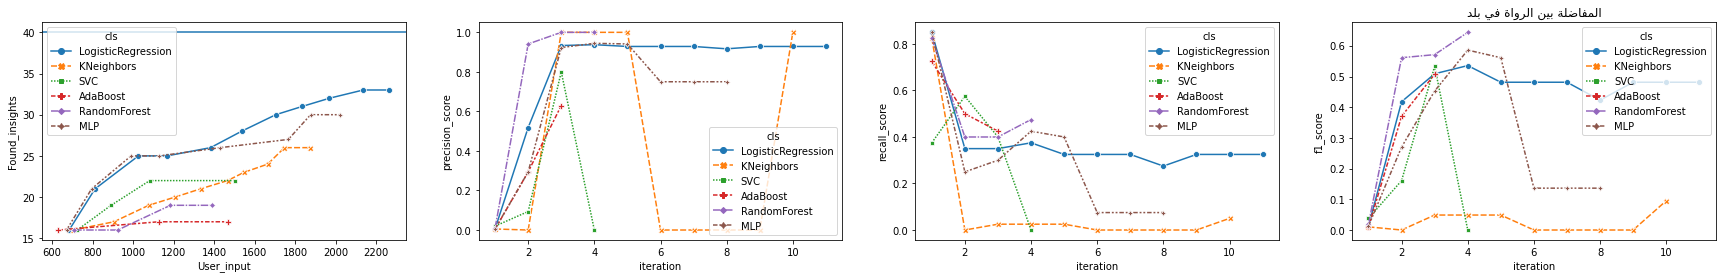

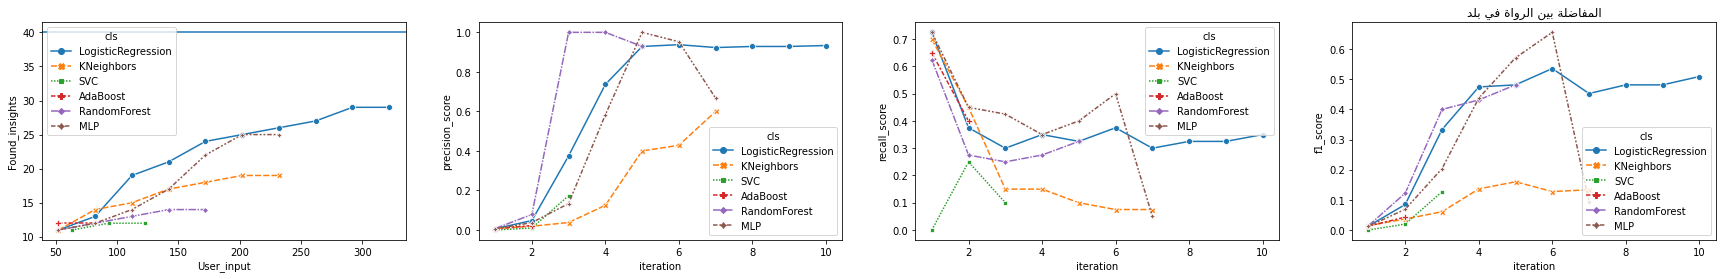

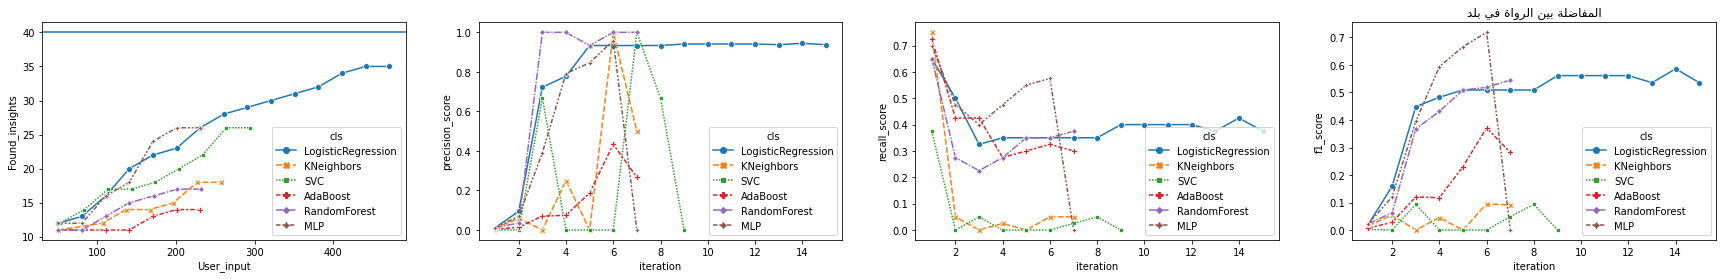

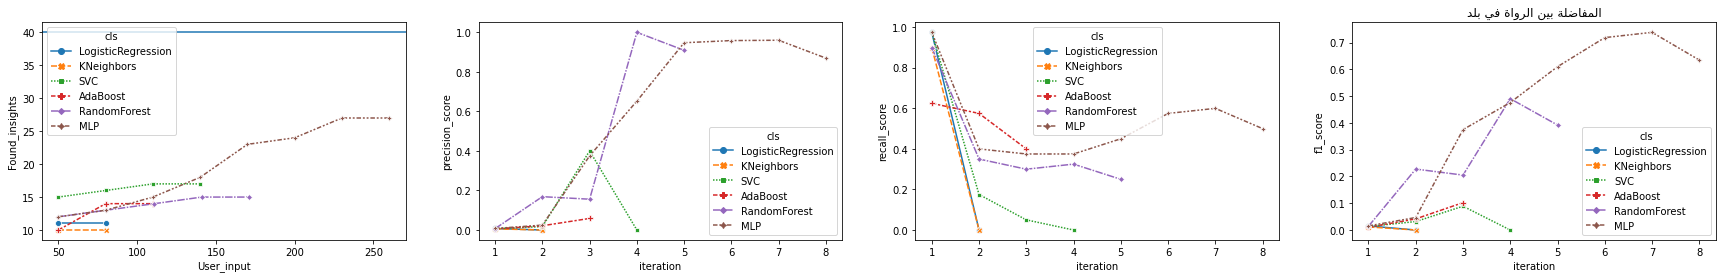

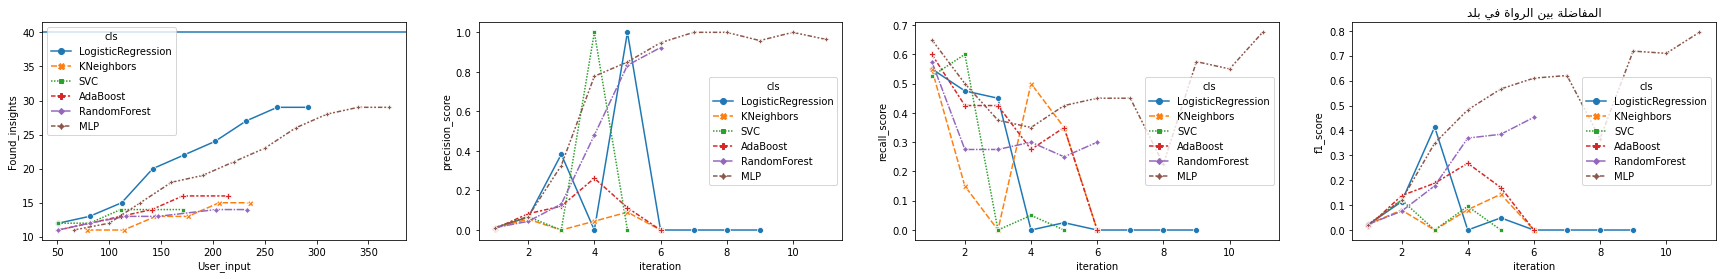

In [ ]:
run_and_plot_cat(categories[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.2s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.6s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.7s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    1.0s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    1.5s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    2.4s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    2.8s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    3.4s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    4.0s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    4.6s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    6.8s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    7.7s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    8.5s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.2s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.5s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.9s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.4s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    2.0s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    2.7s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    3.6s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    4.7s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    5.8s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    7.0s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    8.1s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    9.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 25 is smaller than n_iter=50. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 25 is smaller than n_iter=50. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 25 is smaller than n_iter=50. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   15.9s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.3s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   19.7s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   20.7s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   21.9s finished


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.0s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.3s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.5s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.7s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.9s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    2.1s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    2.3s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    2.5s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 237 out of 240 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.7s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    1.0s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    1.3s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    1.6s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    2.5s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    2.9s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    3.4s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    4.0s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    4.7s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.3s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.6s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.9s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.4s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    2.1s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    2.7s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    3.5s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    4.5s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    5.5s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    6.6s finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    8.0s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 25 is smaller than n_iter=50. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 25 is smaller than n_iter=50. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 25 is smaller than n_iter=50. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   15.9s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.5s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.7s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   19.6s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   20.8s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   21.9s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   22.8s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   24.3s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   25.1s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   26.7s finished


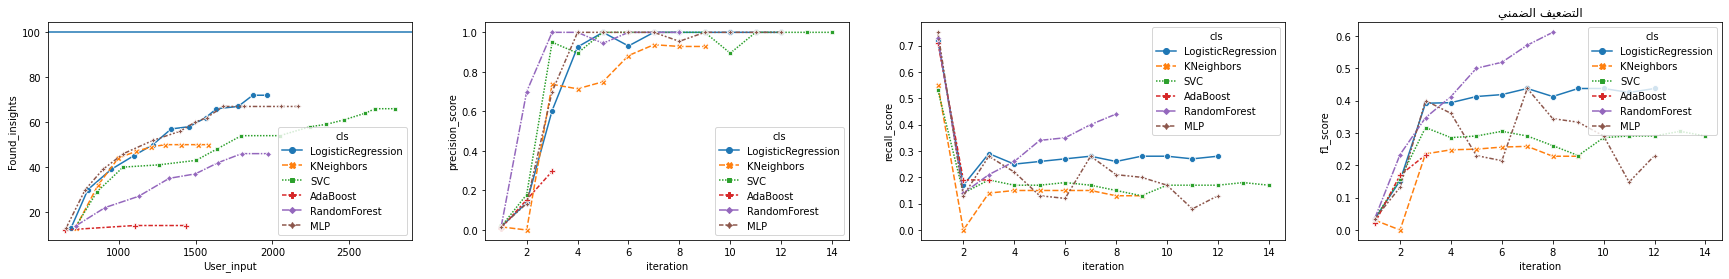

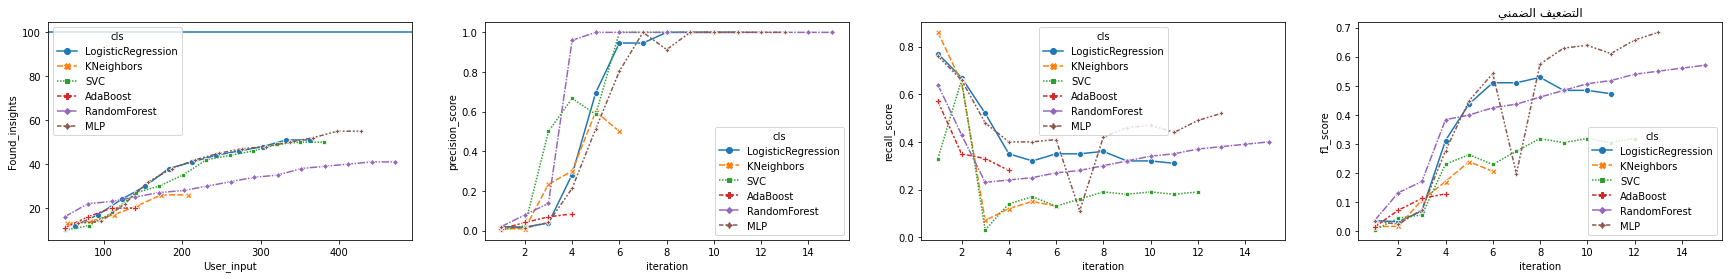

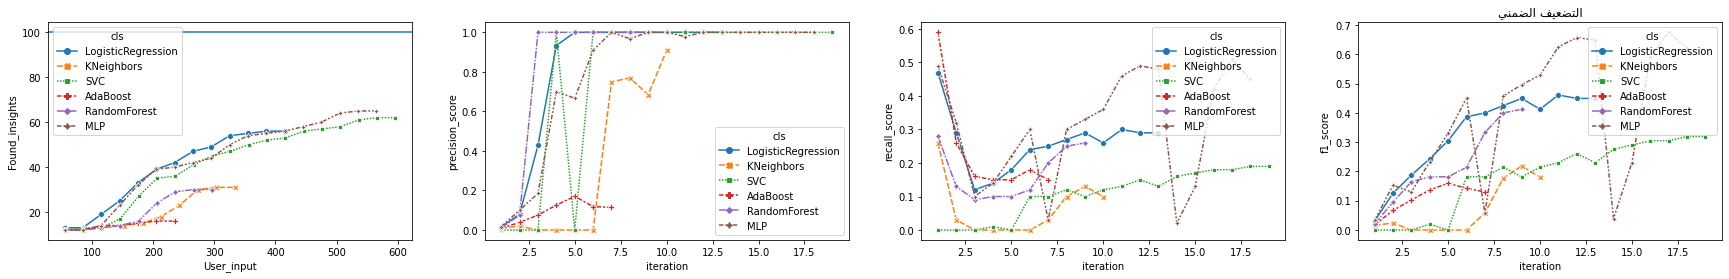

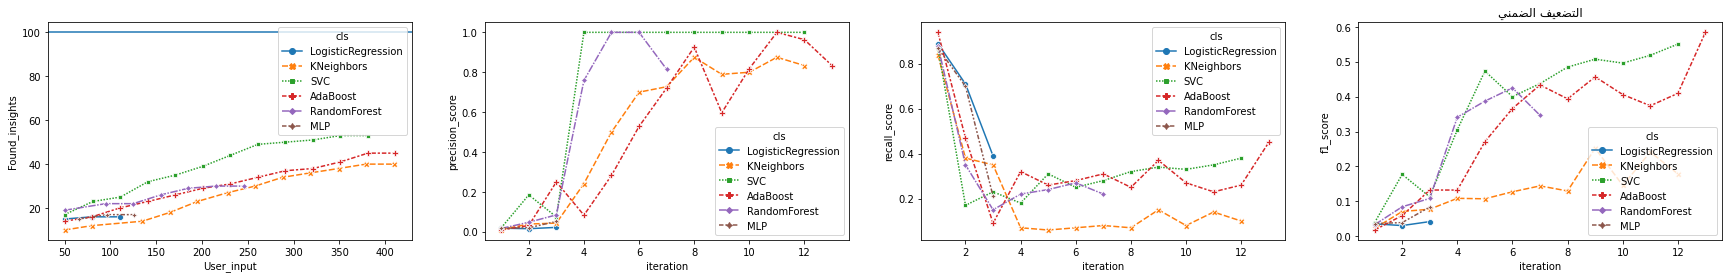

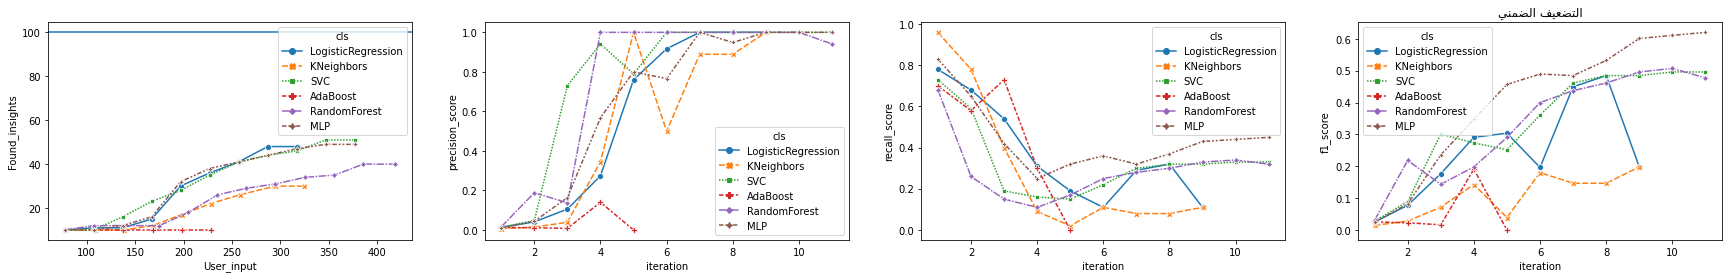

In [ ]:
run_and_plot_cat(categories[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


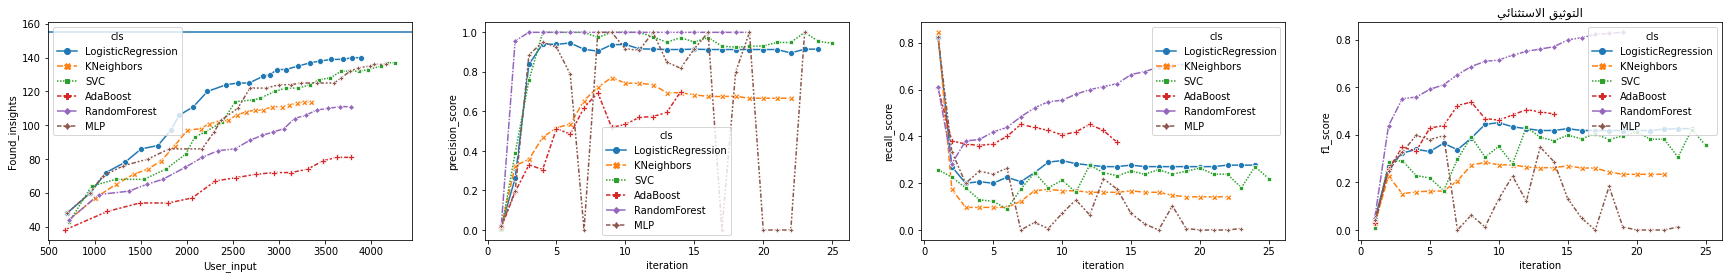

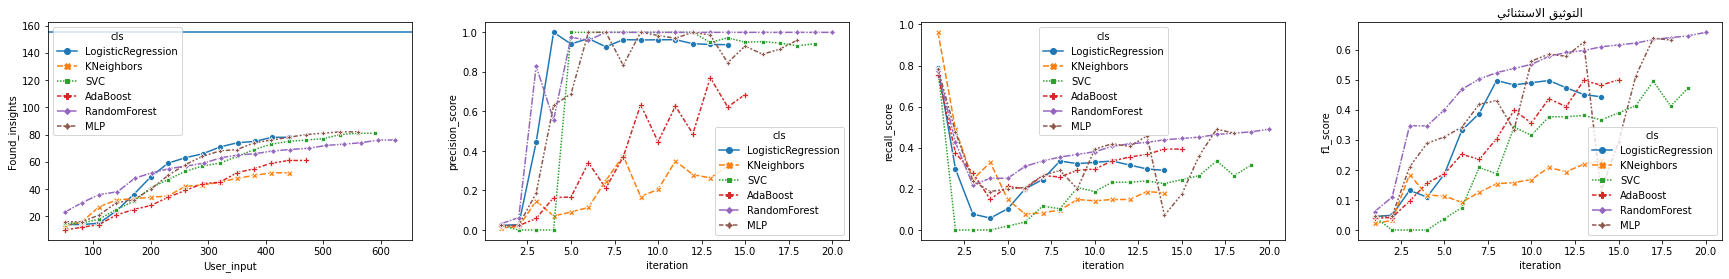

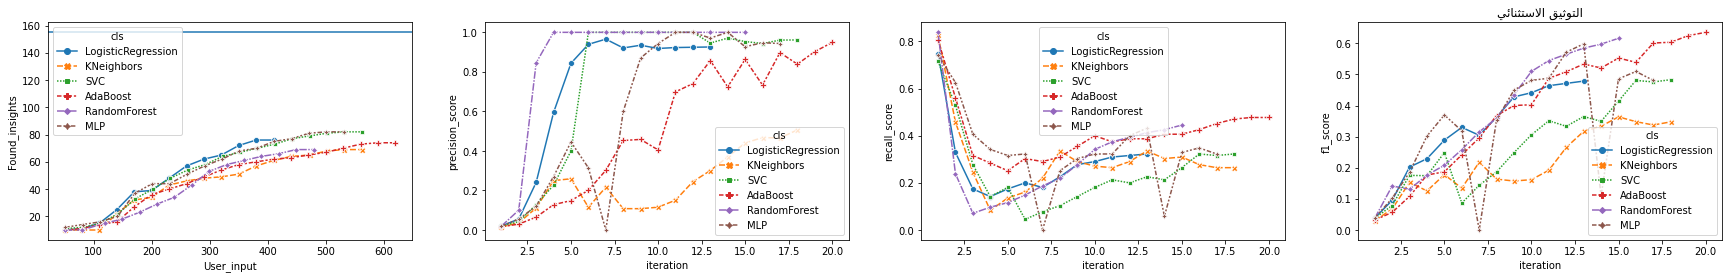

In [ ]:
run_and_plot_cat(categories[2])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


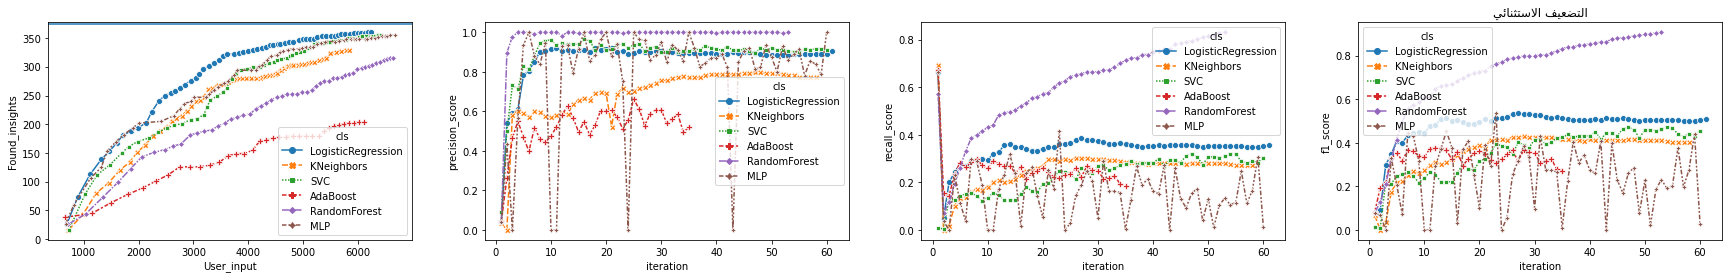

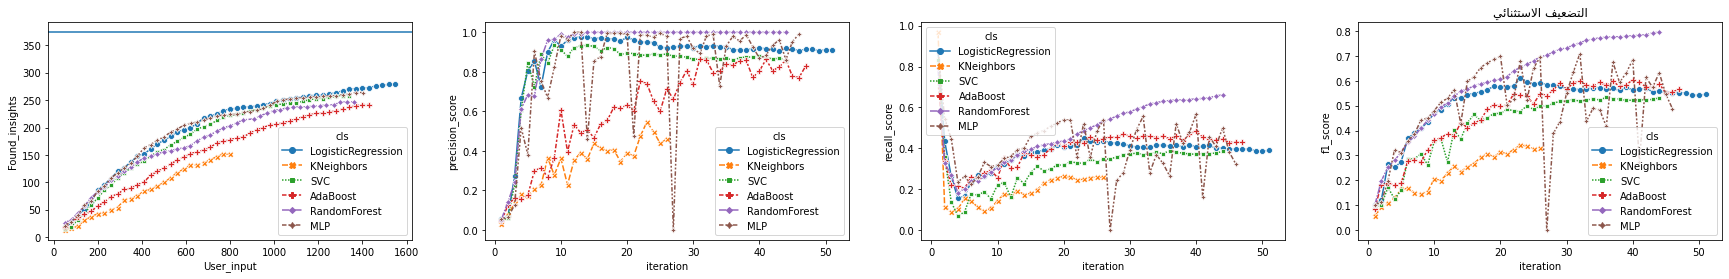

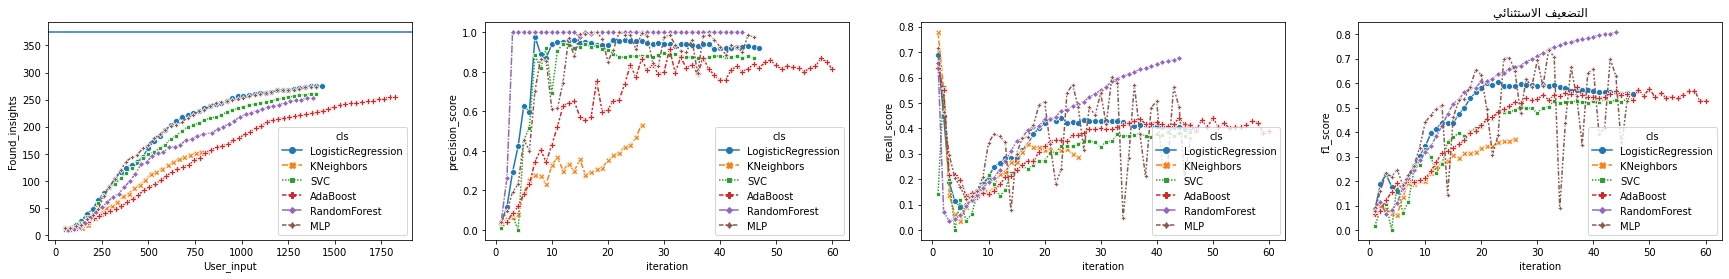

In [ ]:
run_and_plot_cat(categories[3])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


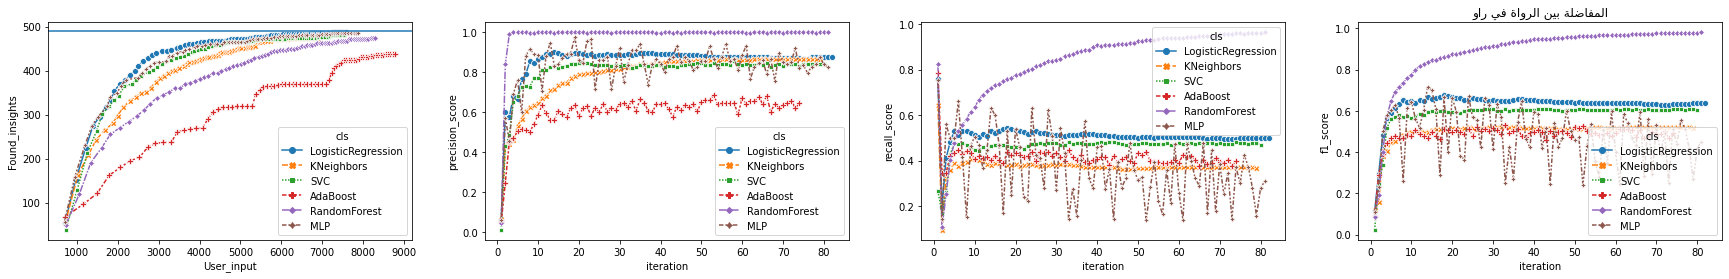

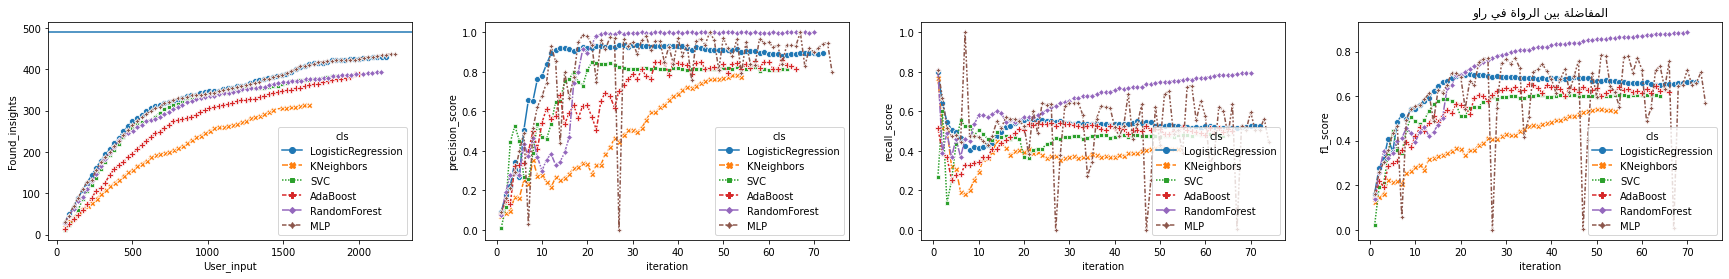

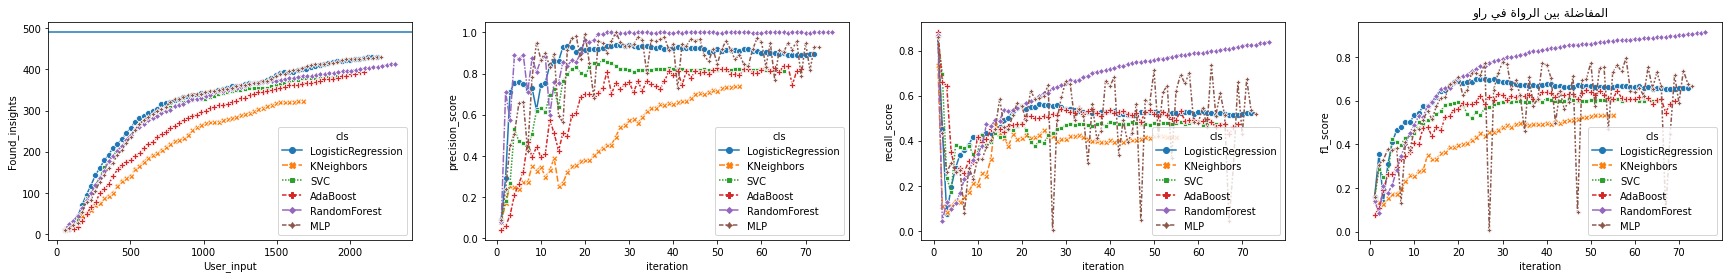

In [ ]:
run_and_plot_cat(categories[4])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[{'cls': 'LogisticRegression', 'iteration': 1, 'User_input': 661, 'Found_insights': 50, 'precision_score': 0.05291697830964847, 'recall_score': 0.6072961373390557, 'f1_score': 0.09735122119023047, 'Model Parameters': 'default'}, {'cls': 'LogisticRegression', 'iteration': 2, 'User_input': 877, 'Found_insights': 64, 'precision_score': 0.1875, 'recall_score': 0.27682403433476394, 'f1_score': 0.22357019064124783, 'Model Parameters': 'default'}, {'cls': 'LogisticRegression', 'iteration': 3, 'User_input': 1064, 'Found_insights': 84, 'precision_score': 0.3237410071942446, 'recall_score': 0.09656652360515021, 'f1_score': 0.14876033057851237, 'Model Parameters': 'default'}, {'cls': 'LogisticRegression', 'iteration': 4, 'User_input': 1165, 'Found_insights': 91, 'precision_score': 0.313953488372093, 'recall_score': 0.11587982832618025, 'f1_score': 0.16927899686520376, 'Model Parameters': 'default'}, {'cls': 'LogisticRegression', 'iteration': 5, 'User_input': 1273, 'Found_insights': 114, 'precisi

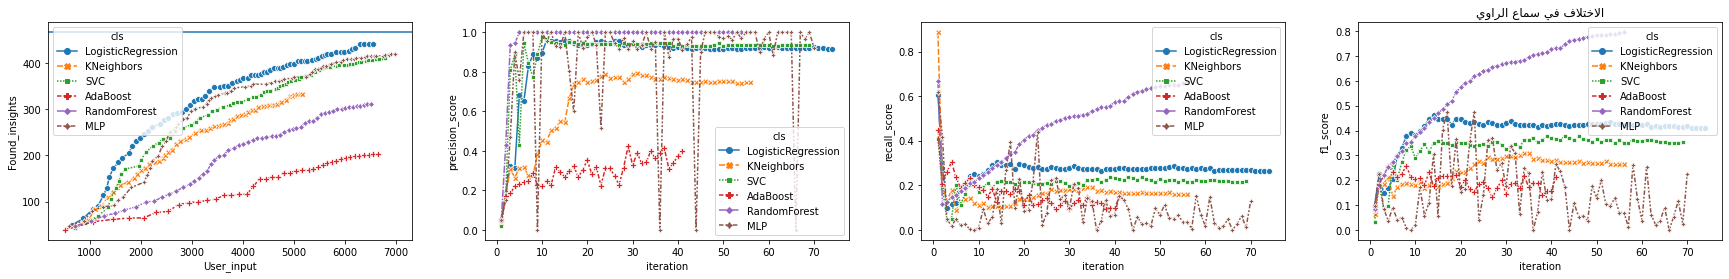

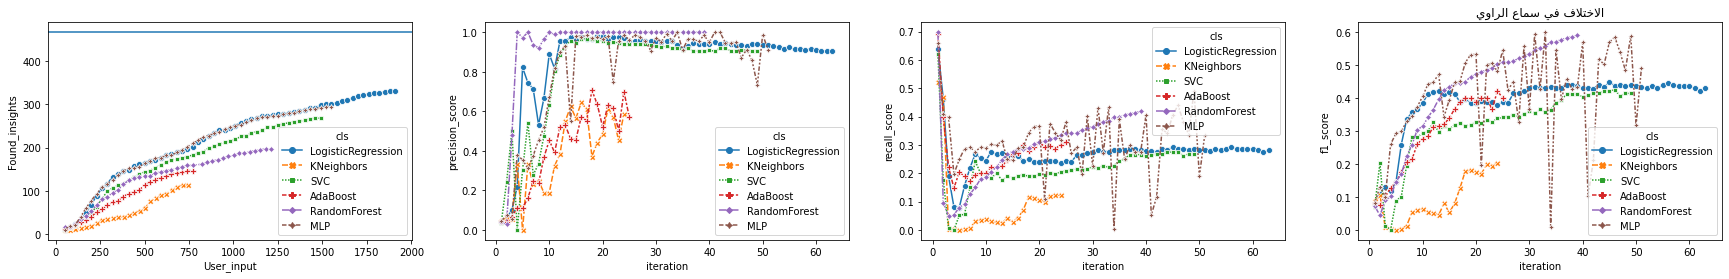

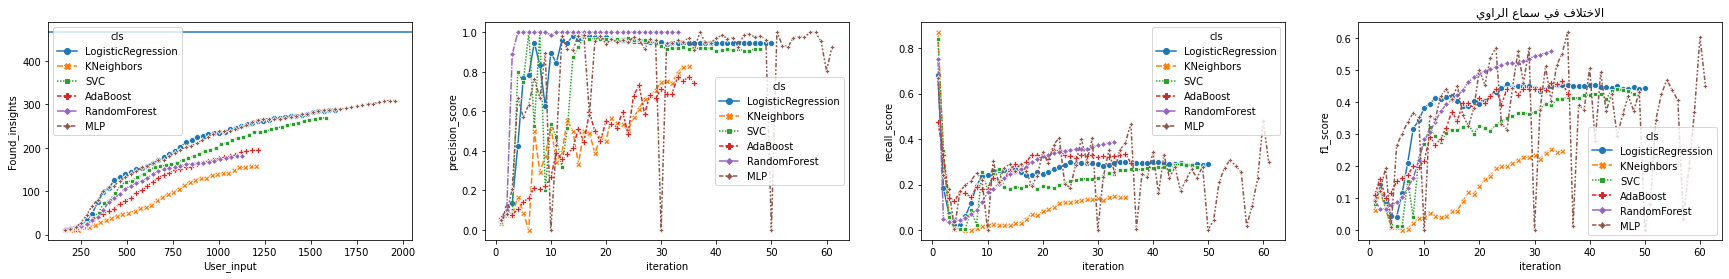

In [ ]:
run_and_plot_cat(categories[5])

In [ ]:
run_and_plot_cat(categories[6])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [ ]:
run_and_plot_cat(categories[7])

In [ ]:
run_and_plot_cat(categories[8])

In [ ]:
run_and_plot_cat(categories[9])

In [ ]:
run_and_plot_cat(categories[10])

In [ ]:
run_and_plot_cat(categories[11])

In [ ]:
run_and_plot_cat(categories[12])

In [ ]:
#lime
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

In [ ]:
'''
idx = 6590
cat = 0
cls = 'svm'
explainer = LimeTextExplainer(class_names=[categories[cat],"Clean"])


exp = explainer.explain_instance(df_corpus.iat[idx], mypred, num_features=6)
exp.show_in_notebook(text=True)
'''

In [ ]:
#confusion matrix


###Results:
* Which tags are suitable for this? Based in the amount of data that is available for the tag
* Does the initial grain size play a role in the overall performance? 
* What is the best simple classifier?
* When do we halt? Number of iteration vs no new vs poor persicion

###Production:
* Create interactive ui that is used for scenarios 
* How is google learns based on user interaction

#Next Week:

* Experiment to find best pipeline settings V2
* Bio aggregation + boundry runs (sum, avg, max) V3
* tuning once stuck V3
* Grades Classification (Final Project)

May:
* dimenstionanlity reduction V4
* Write-up + PRES score implementation
* general purpose UI + best pipeline
